In [2]:
!git clone https://github.com/ankishb/fun-projects.git

Cloning into 'fun-projects'...
remote: Enumerating objects: 46, done.
remote: Counting objects: 100% (46/46), done.
remote: Compressing objects: 100% (35/35), done.
remote: Total 46 (delta 14), reused 25 (delta 8), pack-reused 0
Unpacking objects: 100% (46/46), done.


In [0]:
file_path = 'fun-projects/amazon-ml/'

In [0]:
from tqdm import tqdm
import pandas as pd
import numpy as np
tqdm.pandas()
import matplotlib.pyplot as plt
%matplotlib inline

import os, gc, json, operator, re
import seaborn as sns

import warnings
warnings.filterwarnings("ignore")

pd.set_option('display.max_rows', 200)
pd.set_option('display.max_columns', 200)


sns.set(context='notebook', style='whitegrid', 
        palette='deep', font='sans-serif', 
        font_scale=2, color_codes=True, rc=None)

In [5]:
train = pd.read_csv(file_path+'Dataset/train.csv')
test  = pd.read_csv(file_path+'Dataset/test.csv')
sub   = pd.read_csv(file_path+'Dataset/Sample_Submission.csv')
print(train.shape, test.shape, sub.shape)


train.rename(columns={'Review Text':'text', 'Review Title':'title'}, inplace=True)
test.rename(columns={'Review Text':'text', 'Review Title':'title'}, inplace=True)

df = train.append(test, ignore_index=True)
df['save_text']  = df['text']
df['save_title'] = df['title']

df['text']  = df['text'].str.lower()
df['title'] = df['title'].str.lower()

with open(file_path+'contraction_mapping.txt') as f:
    contraction_mapping = json.loads(f.read())

def correct_contraction(x, dic):
    for word in dic.keys():
        if word in x:
            x = x.replace(word, dic[word])
    return x

df['text']  = df['text'].progress_apply(lambda x: correct_contraction(x, contraction_mapping))
df['title'] = df['title'].progress_apply(lambda x: correct_contraction(x, contraction_mapping))



 48%|████▊     | 4056/8512 [00:00<00:00, 40531.05it/s]

(5959, 3) (2553, 2) (5, 3)


100%|██████████| 8512/8512 [00:00<00:00, 114983.13it/s]


In [6]:
with open(file_path+'punctuation.txt', 'r') as f:
    extra_punct = json.loads(f.read())

import string
my_punct = list(string.punctuation)
all_punct = list(set(my_punct + extra_punct))

special_punc_mappings = {"—": "-", "–": "-", "_": "-", '”': '"', "″": '"', '“': '"', '•': '.', '−': '-',
                         "’": "'", "‘": "'", "´": "'", "`": "'", '\u200b': ' ', '\xa0': ' ','،':'','„':'',
                         '…': ' ... ', '\ufeff': ''}

def spacing_punctuation(text):
    """
    add space before and after punctuation and symbols
    """
    for punc in all_punct:
        if punc in text:
            text = text.replace(punc, f' {punc} ')
    return text

def clean_special_punctuations(text):
    for punc in special_punc_mappings:
        if punc in text:
#             print(punc)
            text = text.replace(punc, special_punc_mappings[punc])
    return text



def preprocess(text):
    text = spacing_punctuation(text)
    text = clean_special_punctuations(text)
    return text


df["text"] = df["text"].progress_apply(preprocess)
df['text'] = df['text'].str.replace(r'\b\w\b','').str.replace(r'\s+', ' ')
df['text'].replace({r'[^\x00-\x7F]+':''}, regex=True, inplace=True)
df['text'].replace({'  ':' '}, regex=True, inplace=True)

df["title"] = df["title"].progress_apply(preprocess)
df['title'] = df['title'].str.replace(r'\b\w\b','').str.replace(r'\s+', ' ')
df['title'].replace({r'[^\x00-\x7F]+':''}, regex=True, inplace=True)
df['title'].replace({'  ':' '}, regex=True, inplace=True)

import re
def clean_text(text):
    text = text.lower()
    text = re.sub(r'@[a-zA-Z0-9_]+', '', text)   
    text = re.sub(r'https?://[A-Za-z0-9./]+', '', text)   
    text = re.sub(r'www.[^ ]+', '', text)  
    text = re.sub(r'[a-zA-Z0-9]*www[a-zA-Z0-9]*com[a-zA-Z0-9]*', '', text)  
    text = re.sub(r'[^a-zA-Z]', ' ', text)   
    text = [token for token in text.split() if len(token) > 2]
    text = ' '.join(text)
    return text

df['text']   = df['text'].progress_apply(clean_text)
df['title']  = df['title'].progress_apply(clean_text)

def clean_text(x):
    x = str(x)
    for punct in "/-'":
        x = x.replace(punct, ' ')
    for punct in '&':
        x = x.replace(punct, f' {punct} ')
    for punct in '?!.,"#$%\'()*+-/:;<=>@[\\]^_`{|}~' + '“”’':
        x = x.replace(punct, '')
    return x

df['text'] = df['text'].progress_apply(clean_text)
df['title'] = df['title'].progress_apply(clean_text)

train1 = df[:train.shape[0]]
test1  = df[train.shape[0]:]
train1.shape, test1.shape

100%|██████████| 8512/8512 [00:00<00:00, 102900.41it/s]


((5959, 5), (2553, 5))

In [7]:
train1['topic'] = train1['topic'].apply(lambda x: "_".join(x.split(" ")))
gp = train1.groupby(['text','title']).agg({
        "topic": lambda x: " ".join(x.values)
    })
train2 = pd.DataFrame(gp.reset_index())

test1['topic'] = 'null'
gp = test1.groupby(['text','title']).agg({
        "topic": lambda x: " ".join(x.values)
    })
test2 = pd.DataFrame(gp.reset_index())

# train2.head().append(test2.head())
print(train2.shape, test2.shape)

(4210, 3) (1773, 3)


In [8]:
train3 = pd.merge(train1[['text','title']], train2, how='left')
test3  = pd.merge(test1[['text','title']], test2, how='left')

train3['labels'] = train3['topic'].apply(lambda x: len(x.split(" ")))
test3['labels']  = test3['topic'].apply(lambda x: len(x.split(" ")))

# train3.head().append(test3.head())
print(train3.shape, test3.shape)

(5959, 4) (2553, 4)


In [9]:
df1 = train2.append(test2, ignore_index=True)

print("Old table : ", df.shape, train.shape, test.shape) 
print("New Table : ", df1.shape, train2.shape, test2.shape)


labels = train1['topic'].values

train['target'] = train['topic'].astype('category').cat.codes
train['target'] = train['target'].astype('int')

def get_mapping(df, col_name):
    cat_codes = df[col_name].astype('category')
    
    class_mapping = {}
    i = 0
    for col in cat_codes.cat.categories:
        class_mapping[col] = i
        i += 1
    
    class_mapping_reverse = {}
    for key, value in class_mapping.items():
        class_mapping_reverse[value] = key

    return class_mapping, class_mapping_reverse

cl_map, cl_map_inv = get_mapping(train, 'topic')


cl_map1 = {}
for key, value in cl_map.items():
    cl_map1["_".join(key.split(" "))] = value
    
cl_map1

Old table :  (8512, 5) (5959, 3) (2553, 2)
New Table :  (5983, 3) (4210, 3) (1773, 3)


{'Allergic': 0,
 'Bad_Taste/Flavor': 1,
 'Color_and_texture': 2,
 'Customer_Issues': 3,
 'Customer_Service': 4,
 "Didn't_Like": 5,
 'Expiry': 6,
 'False_Advertisement': 7,
 'Hard_to_Chew': 8,
 'Inferior_to_competitors': 9,
 'Ingredients': 10,
 'Not_Effective': 11,
 'Packaging': 12,
 'Pricing': 13,
 'Quality/Contaminated': 14,
 'Shipment_and_delivery': 15,
 'Smells_Bad': 16,
 'Texture': 17,
 'Too_Sweet': 18,
 'Too_big_to_swallow': 19,
 'Wrong_Product_received': 20}

In [10]:
labels = train2['topic'].values
lt = np.zeros((df1.shape[0], 21))
j = -1
for key, value in cl_map1.items():
    j += 1
    for i, label in enumerate(labels):
#         print(label)
        if key in label:
            lt[i][j] = 1

print(lt.sum(axis=0))
l_table = pd.DataFrame(data=lt, columns=list(cl_map1.keys()))
l_table = l_table.astype('int')
print(l_table.shape)
# l_table.head()

[ 567. 1192.  233.    8.  239.   31.  135.   37.    6.   44.  215.  605.
  466.  107.  712.  387.  123.  410.   97.  228.   99.]
(5983, 21)


In [0]:
import gc
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.decomposition import TruncatedSVD, NMF

def tfidf_feature(train, test, col_name, min_df=3, analyzer='word', 
                  token_pattern=r'\w{1,}', ngram=3, stopwords='english', 
                  n_component=120, decom_flag=False, which_method='svd', 
                  max_features=None, feat_col_name='svd'):

    tfv = TfidfVectorizer(min_df=min_df,  max_features=max_features, 
                strip_accents='unicode', analyzer=analyzer, max_df=0.95, 
                token_pattern=token_pattern, ngram_range=(1, ngram), 
                use_idf=1, smooth_idf=1, sublinear_tf=1,
                stop_words = stopwords)

    complete_df = pd.concat([train[col_name], test[col_name]], axis=0)
#         return complete_df
#         print(complete_df.shape, complete_df.columns)

    tfv.fit(list(complete_df[:].values))

    if decom_flag is False:
        train_tfv =  tfv.transform(train[col_name].values.ravel()) 
        test_tfv  = tfv.transform(test[col_name].values.ravel())

        del complete_df
        gc.collect()
        return train_tfv, test_tfv, tfv
    else:
        complete_tfv = tfv.transform(complete_df[:].values.ravel())
        
        if which_method is 'svd':
            svd = TruncatedSVD(n_components=n_component)
            svd.fit(complete_tfv)
            complete_dec = svd.transform(complete_tfv)
        else:
            nmf = NMF(n_components=n_component, random_state=1234, alpha=0, l1_ratio=0)
            nmf.fit(complete_tfv)            
            complete_dec = nmf.fit_transform(complete_tfv)            
        
        
        complete_dec = pd.DataFrame(data=complete_dec)
        complete_dec.columns = [feat_col_name+'_'+str(i) for i in range(n_component)]

        train_dec = complete_dec.iloc[:train.shape[0]]
        test_dec = complete_dec.iloc[train.shape[0]:].reset_index(drop=True)

        del complete_dec, complete_df
        gc.collect()
        print("="*15, " done ", "="*15)
        return train_dec, test_dec, complete_tfv, tfv

def countvect_feature(train, test, col_name, min_df=3, 
                      analyzer='word', token_pattern=r'\w{1,}', 
                      ngram=3, stopwords='english', max_features=None):

    ctv = CountVectorizer(min_df=min_df,  max_features=max_features, 
                strip_accents='unicode', analyzer=analyzer, 
                token_pattern=token_pattern, ngram_range=(1, ngram), 
                stop_words = stopwords)

    complete_df = pd.concat([train[col_name], test[col_name]], axis=0)
    ctv.fit(list(complete_df[:].values))

    train_tf =  ctv.transform(train[col_name].values.ravel()) 
    test_tf  = ctv.transform(test[col_name].values.ravel())

    del complete_df
    gc.collect()
    return train_tf, test_tf, ctv


def get_count_vectorizer(df, col_name, min_df=3, analyzer='word', stopwords='english', 
                     token_pattern=r'\w{1,}', ngram=3, max_features=None):
    ctv = CountVectorizer(min_df=min_df,  max_features=max_features, 
                strip_accents='unicode', analyzer=analyzer, 
                token_pattern=token_pattern, ngram_range=(1, ngram), 
                stop_words = stopwords)

    ctv.fit(list(df[col_name].values))

    df_new =  ctv.transform(df[col_name].values.ravel()) 
    return df_new


def get_tfidf_feature(df, col_name, min_df=3, analyzer='word', stopwords='english',
                  token_pattern=r'\w{1,}', ngram=3, max_features=None):

    tfv = TfidfVectorizer(min_df=min_df,  max_features=max_features, 
                strip_accents='unicode', analyzer=analyzer, max_df=0.95, 
                token_pattern=token_pattern, ngram_range=(1, ngram), 
                use_idf=1, smooth_idf=1, sublinear_tf=1,
                stop_words = stopwords)

    tfv.fit(list(df[col_name].values))
    df_new =  tfv.transform(df[col_name].values.ravel()) 
    
    return df_new



In [12]:
!wget http://nlp.stanford.edu/data/glove.6B.zip

--2019-08-11 10:12:06--  http://nlp.stanford.edu/data/glove.6B.zip
Resolving nlp.stanford.edu (nlp.stanford.edu)... 171.64.67.140
Connecting to nlp.stanford.edu (nlp.stanford.edu)|171.64.67.140|:80... connected.
HTTP request sent, awaiting response... 302 Found
Location: https://nlp.stanford.edu/data/glove.6B.zip [following]
--2019-08-11 10:12:06--  https://nlp.stanford.edu/data/glove.6B.zip
Connecting to nlp.stanford.edu (nlp.stanford.edu)|171.64.67.140|:443... connected.
HTTP request sent, awaiting response... 301 Moved Permanently
Location: http://downloads.cs.stanford.edu/nlp/data/glove.6B.zip [following]
--2019-08-11 10:12:06--  http://downloads.cs.stanford.edu/nlp/data/glove.6B.zip
Resolving downloads.cs.stanford.edu (downloads.cs.stanford.edu)... 171.64.64.22
Connecting to downloads.cs.stanford.edu (downloads.cs.stanford.edu)|171.64.64.22|:80... connected.
HTTP request sent, awaiting response... 200 OK
Length: 862182613 (822M) [application/zip]
Saving to: ‘glove.6B.zip’

glove.6

In [13]:
!unzip glove.6B.zip

Archive:  glove.6B.zip
  inflating: glove.6B.50d.txt        
  inflating: glove.6B.100d.txt       
  inflating: glove.6B.200d.txt       
  inflating: glove.6B.300d.txt       


In [14]:
!ls

fun-projects	   glove.6B.200d.txt  glove.6B.50d.txt	sample_data
glove.6B.100d.txt  glove.6B.300d.txt  glove.6B.zip


In [15]:
embeddings_index = {}
f = open('glove.6B.300d.txt')
for line in tqdm(f):
    values = line.split()
    word = values[0]
    coefs = np.asarray(values[1:], dtype='float32')
    embeddings_index[word] = coefs
f.close()

print('Found %s word vectors.' % len(embeddings_index))

400000it [00:32, 12212.06it/s]

Found 400000 word vectors.


In [16]:
print(train2.shape, test2.shape)

df1['topic1'] = df1['topic']
df1['topic'] = df1['topic1'].apply(lambda x: x.split(" ")[0])
train4 = df1[:train2.shape[0]]
test4  = df1[train2.shape[0]:]
train4.drop('topic1', axis=1, inplace=True)
test4.drop('topic1', axis=1, inplace=True)
print(train4.shape, test4.shape)


df3 = train4.append(test4, ignore_index=True)
print(df3.shape)


(4210, 3) (1773, 3)
(4210, 3) (1773, 3)
(5983, 3)


In [17]:
train4.shape, df3.shape, train4.columns

((4210, 3), (5983, 3), Index(['text', 'title', 'topic'], dtype='object'))

In [0]:
train4['target'] = train4['topic'].astype('category').cat.codes
train4['target'] = train4['target'].astype('int')

In [15]:
from sklearn.model_selection import train_test_split
X_train, X_test, Y_train, Y_test = train_test_split(
    df3[:train4.shape[0]][['text','title']], train4['target'], 
    stratify=train4['target'], 
    test_size=0.25
)
X_train.shape, Y_train.shape, X_test.shape, Y_test.shape

((3157, 2), (3157,), (1053, 2), (1053,))

In [19]:
from sklearn.model_selection import train_test_split
X_train, X_test, Y_train, Y_test = train_test_split(
    df3[:train4.shape[0]][['text','title']], l_table[:train4.shape[0]], 
    stratify=train4['target'], 
    test_size=0.25
)
X_train.shape, Y_train.shape, X_test.shape, Y_test.shape

((3157, 2), (3157, 21), (1053, 2), (1053, 21))

In [20]:
!pip install nltk
import nltk
nltk.download('stopwords')
nltk.download('punkt')

[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Unzipping corpora/stopwords.zip.
[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Unzipping tokenizers/punkt.zip.


True

In [0]:
from nltk import word_tokenize
from nltk.corpus import stopwords
stop_words = stopwords.words('english')

# this function creates a normalized vector for the whole sentence
def sent2vec(s):
    words = str(s).lower()#.decode('utf-8')
    words = word_tokenize(words)
    words = [w for w in words if not w in stop_words]
    words = [w for w in words if w.isalpha()]
    M = []
    for w in words:
        try:
            M.append(embeddings_index[w])
        except:
            continue
    M = np.array(M)
    v = M.sum(axis=0)
    if type(v) != np.ndarray:
        return np.zeros(300)
    return v / np.sqrt((v ** 2).sum())

# create sentence vectors using the above function for training and validation set
xtrain_glove = [sent2vec(x) for x in X_train['text']]
xvalid_glove = [sent2vec(x) for x in X_test['text']]

In [26]:
del xtrain_glove, xvalid_glove
gc.collect()

17

In [21]:
from keras.models import Sequential
from keras.layers.recurrent import LSTM, GRU
from keras.layers.core import Dense, Activation, Dropout
from keras.layers.embeddings import Embedding
from keras.layers.normalization import BatchNormalization
from keras.utils import np_utils
from keras.layers import GlobalMaxPooling1D, Conv1D, MaxPooling1D, Flatten, Bidirectional, SpatialDropout1D
from keras.preprocessing import sequence, text


Using TensorFlow backend.


In [0]:
from keras.models import Sequential
from keras.optimizers import Adam
from keras import Model

from keras.layers import Bidirectional, CuDNNLSTM, LSTM, CuDNNGRU, GRU, Embedding
from keras.layers import Dense, Input, Dropout, Activation, Conv1D, Flatten, Concatenate
from keras.layers import SpatialDropout1D, Dropout, GlobalMaxPooling1D, MaxPooling1D

from keras.regularizers import l2

from keras.preprocessing.text import Tokenizer
from keras.preprocessing.sequence import pad_sequences
from keras.callbacks import ModelCheckpoint, Callback, EarlyStopping,ReduceLROnPlateau


In [0]:
from keras.engine.topology import Layer
from keras import backend as K
from keras import initializers, regularizers, constraints, optimizers, layers
class Attention(Layer):
    def __init__(self, step_dim, W_regularizer=None, b_regularizer=None, W_constraint=None, b_constraint=None, bias=True, **kwargs):
        self.supports_masking = True
        self.init = initializers.get('glorot_uniform')

        self.W_regularizer = regularizers.get(W_regularizer)
        self.b_regularizer = regularizers.get(b_regularizer)

        self.W_constraint = constraints.get(W_constraint)
        self.b_constraint = constraints.get(b_constraint)

        self.bias = bias
        self.step_dim = step_dim
        self.features_dim = 0
        super(Attention, self).__init__(**kwargs)

    def build(self, input_shape):
        assert len(input_shape) == 3

        self.W = self.add_weight((input_shape[-1],),
                                 initializer=self.init,
                                 name='{}_W'.format(self.name),
                                 regularizer=self.W_regularizer,
                                 constraint=self.W_constraint)
        self.features_dim = input_shape[-1]

        if self.bias:
            self.b = self.add_weight((input_shape[1],),
                                     initializer='zero',
                                     name='{}_b'.format(self.name),
                                     regularizer=self.b_regularizer,
                                     constraint=self.b_constraint)
        else:
            self.b = None

        self.built = True

    def compute_mask(self, input, input_mask=None):
        return None

    def call(self, x, mask=None):
        features_dim = self.features_dim
        step_dim = self.step_dim

        eij = K.reshape(K.dot(K.reshape(x, (-1, features_dim)),
                        K.reshape(self.W, (features_dim, 1))), (-1, step_dim))

        if self.bias: eij += self.b
        eij = K.tanh(eij)
        a = K.exp(eij)

        if mask is not None:
            a *= K.cast(mask, K.floatx())

        a /= K.cast(K.sum(a, axis=1, keepdims=True)+K.epsilon(), K.floatx())
        a = K.expand_dims(a)
        weighted_input = x * a
        return K.sum(weighted_input, axis=1)

    def compute_output_shape(self, input_shape):
        return input_shape[0],  self.features_dim


In [24]:
# using keras tokenizer here
token = text.Tokenizer(num_words=None)
max_len = 128
max_len2 = 17

token.fit_on_texts(list(X_train['text']) + list(X_test['text']))
xtrain_seq = token.texts_to_sequences(X_train['text'])
xvalid_seq = token.texts_to_sequences(X_test['text'])
xtest_seq  = token.texts_to_sequences(test4['text'])

# zero pad the sequences
xtrain_pad = sequence.pad_sequences(xtrain_seq, maxlen=max_len)
xvalid_pad = sequence.pad_sequences(xvalid_seq, maxlen=max_len)
xtest_pad  = sequence.pad_sequences(xtest_seq, maxlen=max_len)

word_index = token.word_index

# create an embedding matrix for the words we have in the dataset
embedding_matrix = np.zeros((len(word_index) + 1, 300))
for word, i in tqdm(word_index.items()):
    embedding_vector = embeddings_index.get(word)
    if embedding_vector is not None:
        embedding_matrix[i] = embedding_vector

        
# using keras tokenizer here
token1 = text.Tokenizer(num_words=None)

token1.fit_on_texts(list(X_train['title']) + list(X_test['title']))
xtrain_seq1 = token1.texts_to_sequences(X_train['title'])
xvalid_seq1 = token1.texts_to_sequences(X_test['title'])
xtest_seq1  = token1.texts_to_sequences(test4['title'])

# zero pad the sequences
xtrain_pad1 = sequence.pad_sequences(xtrain_seq1, maxlen=max_len2)
xvalid_pad1 = sequence.pad_sequences(xvalid_seq1, maxlen=max_len2)
xtest_pad1  = sequence.pad_sequences(xtest_seq1, maxlen=max_len2)

word_index1 = token1.word_index

# create an embedding matrix for the words we have in the dataset
embedding_matrix1 = np.zeros((len(word_index1) + 1, 300))
for word, i in tqdm(word_index1.items()):
    embedding_vector = embeddings_index.get(word)
    if embedding_vector is not None:
        embedding_matrix1[i] = embedding_vector

        
        
# ytrain_enc = np_utils.to_categorical(Y_train, num_classes=21)
# yvalid_enc = np_utils.to_categorical(Y_test, num_classes=21)

xtrain_pad.shape, xvalid_pad.shape, xtest_pad.shape, xtrain_pad1.shape, xvalid_pad1.shape, xtest_pad1.shape



100%|██████████| 2367/2367 [00:00<00:00, 232683.75it/s]


((3157, 128), (1053, 128), (1773, 128), (3157, 17), (1053, 17), (1773, 17))

In [44]:
try:
    del model_comp
    gc.collect()
except:
    print("no model previously")
    

# GRU with glove embeddings and two dense layers
max_len2 = 17
inp1 = Input(shape=(max_len,))
inp2 = Input(shape=(max_len2,))

x1 = Embedding(  len(word_index) + 1,
                 300,
                 weights=[embedding_matrix],
                 input_length=max_len,
                 trainable=False)(inp1)
x2 = Embedding(  len(word_index1) + 1,
                 300,
                 weights=[embedding_matrix1],
                 input_length=max_len2,
                 trainable=False)(inp2)

x1 = SpatialDropout1D(0.3)(x1)
x2 = SpatialDropout1D(0.3)(x2)

x1 = Bidirectional(LSTM(200, dropout=0.3, recurrent_dropout=0.3, return_sequences=True, kernel_regularizer=l2(1e-4)))(x1)
x1 = Bidirectional(LSTM(200, dropout=0.3, recurrent_dropout=0.3, return_sequences=True, kernel_regularizer=l2(1e-4)))(x1)

x2 = Bidirectional(LSTM(100, dropout=0.3, recurrent_dropout=0.3, return_sequences=True, kernel_regularizer=l2(1e-4)))(x2)
x2 = Bidirectional(LSTM(100, dropout=0.3, recurrent_dropout=0.3, return_sequences=True, kernel_regularizer=l2(1e-4)))(x2)

x1 = Attention(max_len)(x1)
x2 = Attention(max_len2)(x2)

x1 = Dense(1024, activation='relu', kernel_regularizer=l2(1e-4))(x1)
x1 = Dropout(0.8)(x1)

x2 = Dense(1024, activation='relu', kernel_regularizer=l2(1e-4))(x2)
x2 = Dropout(0.8)(x2)

x = Concatenate(axis=1)([x1,x2])
x = Dense(1024, activation='relu', kernel_regularizer=l2(1e-4))(x)
x = Dropout(0.8)(x)

x = Dense(21, kernel_regularizer=l2(1e-4))(x)
x = Activation('softmax')(x)

model_comp = Model(input=[inp1, inp2], output=x)
model_comp.compile(loss='categorical_crossentropy', optimizer='adam', metrics=['accuracy'])

model_comp.summary()

W0811 06:27:28.797589 140037554907008 nn_ops.py:4224] Large dropout rate: 0.8 (>0.5). In TensorFlow 2.x, dropout() uses dropout rate instead of keep_prob. Please ensure that this is intended.
W0811 06:27:28.841862 140037554907008 nn_ops.py:4224] Large dropout rate: 0.8 (>0.5). In TensorFlow 2.x, dropout() uses dropout rate instead of keep_prob. Please ensure that this is intended.


__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_3 (InputLayer)            (None, 128)          0                                            
__________________________________________________________________________________________________
input_4 (InputLayer)            (None, 17)           0                                            
__________________________________________________________________________________________________
embedding_3 (Embedding)         (None, 128, 300)     2409600     input_3[0][0]                    
__________________________________________________________________________________________________
embedding_4 (Embedding)         (None, 17, 300)      710400      input_4[0][0]                    
__________________________________________________________________________________________________
spatial_dr

In [45]:
epochs = 70
batch_size = 256

reducelr = ReduceLROnPlateau(factor=np.sqrt(0.1), monitor='val_loss', patience=2)
modelcheck = ModelCheckpoint('model_atten_lstm_comb.h5', monitor='val_loss', verbose=0, save_best_only=True, period=2)
earlystop = EarlyStopping(monitor='val_loss', min_delta=0, patience=3, verbose=0, mode='auto')

model_comp.fit(
    x=[xtrain_pad, xtrain_pad1], 
    y=ytrain_enc, 
    batch_size=batch_size, 
    epochs=epochs, 
    verbose=1, 
    validation_data=([xvalid_pad, xvalid_pad1], yvalid_enc), 
    callbacks=[reducelr, modelcheck, earlystop]
)

Train on 3157 samples, validate on 1053 samples
Epoch 1/70
3157/3157 [==============================] - 184s 58ms/step - loss: 3.4169 - acc: 0.1121 - val_loss: 3.1909 - val_acc: 0.1472
Epoch 2/70
3157/3157 [==============================] - 166s 52ms/step - loss: 3.1783 - acc: 0.1375 - val_loss: 3.0392 - val_acc: 0.1871
Epoch 3/70
3157/3157 [==============================] - 168s 53ms/step - loss: 3.0187 - acc: 0.1844 - val_loss: 2.8732 - val_acc: 0.2213
Epoch 4/70
3157/3157 [==============================] - 162s 51ms/step - loss: 2.8616 - acc: 0.2354 - val_loss: 2.6935 - val_acc: 0.2868
Epoch 5/70
3157/3157 [==============================] - 169s 54ms/step - loss: 2.7108 - acc: 0.2838 - val_loss: 2.5858 - val_acc: 0.3162
Epoch 6/70
3157/3157 [==============================] - 168s 53ms/step - loss: 2.6068 - acc: 0.3187 - val_loss: 2.5011 - val_acc: 0.3485
Epoch 7/70
3157/3157 [==============================] - 162s 51ms/step - loss: 2.5130 - acc: 0.3643 - val_loss: 2.4137 - val_acc: 

In [0]:
os.makedirs('submission')

In [53]:
xtest_pad.shape, xtest_pad1.shape

((1773, 128), (1773, 17))

In [54]:
pred11 = model_comp.predict([xtest_pad, xtest_pad1], batch_size=500, verbose=1)
pred111 = np.argmax(pred11, axis=1)
print(pred11.shape)

test4.reset_index(drop=True)
test4['topic'] = pred111
final1 = pd.merge(test1[['text','title','save_text','save_title']], test4, how='left', on=['text','title'])
final1['target'] = final1['topic'].apply(lambda x: cl_map_inv[x])
final1 = final1[['save_text','save_title','target']]
final1.columns = sub.columns
print(final1.shape)
final1.to_csv('submission/deep_att_lstm.csv',index=None)
final1.head()

1773/1773 [==============================] - 25s 14ms/step
(1773, 21)
(2553, 3)


Review Text  \
0  I use chia seed in my protein shakes. These ta...   
1  I use chia seed in my protein shakes. These ta...   
2                            Don’t waste your money.   
3  I use the book 'Fortify Your Life' by Tieraona...   
4  I use the book 'Fortify Your Life' by Tieraona...   

                               Review Title                 topic  
0                                  Bad tast  Quality/Contaminated  
1                                  Bad tast  Quality/Contaminated  
2                    No change. No results.         Not Effective  
3  Good Vegan Choice, Poor Non Vegan Choice           Ingredients  
4  Good Vegan Choice, Poor Non Vegan Choice           Ingredients

In [25]:
try:
    del model_comp1
    gc.collect()
except:
    print("no model previously")
    

# GRU with glove embeddings and two dense layers
max_len2 = 17
inp1 = Input(shape=(max_len,))
inp2 = Input(shape=(max_len2,))

x1 = Embedding(  len(word_index) + 1,
                 300,
                 weights=[embedding_matrix],
                 input_length=max_len,
                 trainable=False)(inp1)
x2 = Embedding(  len(word_index1) + 1,
                 300,
                 weights=[embedding_matrix1],
                 input_length=max_len2,
                 trainable=False)(inp2)

x1 = SpatialDropout1D(0.3)(x1)
x2 = SpatialDropout1D(0.3)(x2)

x1 = Bidirectional(LSTM(120, dropout=0.3, recurrent_dropout=0.3, return_sequences=True, kernel_regularizer=l2(1e-4)))(x1)
x1 = Bidirectional(LSTM(120, dropout=0.3, recurrent_dropout=0.3, return_sequences=True, kernel_regularizer=l2(1e-4)))(x1)

x2 = Bidirectional(LSTM(70, dropout=0.3, recurrent_dropout=0.3, return_sequences=True, kernel_regularizer=l2(1e-4)))(x2)
x2 = Bidirectional(LSTM(70, dropout=0.3, recurrent_dropout=0.3, return_sequences=True, kernel_regularizer=l2(1e-4)))(x2)

x1 = Attention(max_len)(x1)
x2 = Attention(max_len2)(x2)

x1 = Dense(756, activation='relu', kernel_regularizer=l2(1e-4))(x1)
x1 = Dropout(0.7)(x1)

x2 = Dense(756, activation='relu', kernel_regularizer=l2(1e-4))(x2)
x2 = Dropout(0.7)(x2)

x = Concatenate(axis=1)([x1,x2])
x = Dense(756, activation='relu', kernel_regularizer=l2(1e-4))(x)
x = Dropout(0.7)(x)

x = Dense(21, kernel_regularizer=l2(1e-4))(x)
x = Activation('sigmoid')(x)

model_comp1 = Model(input=[inp1, inp2], output=x)
model_comp1.compile(loss='binary_crossentropy', optimizer='adam', metrics=['accuracy'])

model_comp1.summary()

W0811 10:14:19.023206 139968440121216 deprecation_wrapper.py:119] From /usr/local/lib/python3.6/dist-packages/keras/backend/tensorflow_backend.py:74: The name tf.get_default_graph is deprecated. Please use tf.compat.v1.get_default_graph instead.

W0811 10:14:19.070110 139968440121216 deprecation_wrapper.py:119] From /usr/local/lib/python3.6/dist-packages/keras/backend/tensorflow_backend.py:517: The name tf.placeholder is deprecated. Please use tf.compat.v1.placeholder instead.

W0811 10:14:19.083018 139968440121216 deprecation_wrapper.py:119] From /usr/local/lib/python3.6/dist-packages/keras/backend/tensorflow_backend.py:4138: The name tf.random_uniform is deprecated. Please use tf.random.uniform instead.

W0811 10:14:19.100563 139968440121216 deprecation_wrapper.py:119] From /usr/local/lib/python3.6/dist-packages/keras/backend/tensorflow_backend.py:174: The name tf.get_default_session is deprecated. Please use tf.compat.v1.get_default_session instead.

W0811 10:14:19.101979 1399684401

no model previously


W0811 10:14:19.576651 139968440121216 deprecation.py:506] From /usr/local/lib/python3.6/dist-packages/keras/backend/tensorflow_backend.py:3445: calling dropout (from tensorflow.python.ops.nn_ops) with keep_prob is deprecated and will be removed in a future version.
Instructions for updating:
Please use `rate` instead of `keep_prob`. Rate should be set to `rate = 1 - keep_prob`.
W0811 10:14:23.232602 139968440121216 nn_ops.py:4224] Large dropout rate: 0.7 (>0.5). In TensorFlow 2.x, dropout() uses dropout rate instead of keep_prob. Please ensure that this is intended.
W0811 10:14:23.272989 139968440121216 nn_ops.py:4224] Large dropout rate: 0.7 (>0.5). In TensorFlow 2.x, dropout() uses dropout rate instead of keep_prob. Please ensure that this is intended.
W0811 10:14:23.313766 139968440121216 nn_ops.py:4224] Large dropout rate: 0.7 (>0.5). In TensorFlow 2.x, dropout() uses dropout rate instead of keep_prob. Please ensure that this is intended.
W0811 10:14:23.349565 139968440121216 depre

__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_1 (InputLayer)            (None, 128)          0                                            
__________________________________________________________________________________________________
input_2 (InputLayer)            (None, 17)           0                                            
__________________________________________________________________________________________________
embedding_1 (Embedding)         (None, 128, 300)     2409600     input_1[0][0]                    
__________________________________________________________________________________________________
embedding_2 (Embedding)         (None, 17, 300)      710400      input_2[0][0]                    
__________________________________________________________________________________________________
spatial_dr

In [26]:
# del model_comp1
gc.collect()

0

In [27]:
l_table.shape

(5983, 21)

In [28]:
epochs = 70
batch_size = 128

reducelr = ReduceLROnPlateau(factor=np.sqrt(0.1), monitor='val_loss', patience=2)
modelcheck = ModelCheckpoint('model_atten_lstm_comb1.h5', monitor='val_loss', verbose=0, save_best_only=True, period=2)
earlystop = EarlyStopping(monitor='val_loss', min_delta=0, patience=3, verbose=0, mode='auto')

model_comp1.fit(
    x=[xtrain_pad, xtrain_pad1], 
    y=Y_train.values, 
    batch_size=batch_size, 
    epochs=epochs, 
    verbose=1, 
    validation_data=([xvalid_pad, xvalid_pad1], Y_test.values), 
    callbacks=[reducelr, modelcheck, earlystop]
)

Train on 3157 samples, validate on 1053 samples
Epoch 1/70
3157/3157 [==============================] - 103s 33ms/step - loss: 0.6965 - acc: 0.8914 - val_loss: 0.4887 - val_acc: 0.9324
Epoch 2/70
3157/3157 [==============================] - 91s 29ms/step - loss: 0.4425 - acc: 0.9313 - val_loss: 0.3813 - val_acc: 0.9324
Epoch 3/70
3157/3157 [==============================] - 92s 29ms/step - loss: 0.3598 - acc: 0.9336 - val_loss: 0.3201 - val_acc: 0.9361
Epoch 4/70
3157/3157 [==============================] - 92s 29ms/step - loss: 0.3107 - acc: 0.9361 - val_loss: 0.2868 - val_acc: 0.9372
Epoch 5/70
3157/3157 [==============================] - 92s 29ms/step - loss: 0.2844 - acc: 0.9365 - val_loss: 0.2657 - val_acc: 0.9377
Epoch 6/70
3157/3157 [==============================] - 93s 29ms/step - loss: 0.2654 - acc: 0.9366 - val_loss: 0.2505 - val_acc: 0.9380
Epoch 7/70
3157/3157 [==============================] - 92s 29ms/step - loss: 0.2522 - acc: 0.9369 - val_loss: 0.2387 - val_acc: 0.9389

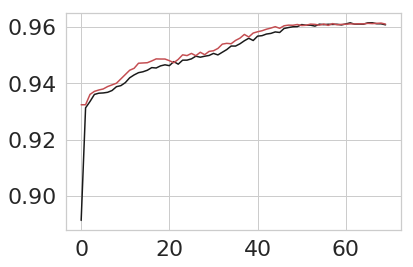

In [30]:
plt.plot(model_comp1.history.history['acc'],c='k')
plt.plot(model_comp1.history.history['val_acc'],c='r')

In [31]:
xtest_pad.shape, xtest_pad1.shape

((1773, 128), (1773, 17))

In [33]:
pred11 = model_comp1.predict([xtest_pad, xtest_pad1], batch_size=250, verbose=1)
pred11.shape

1773/1773 [==============================] - 14s 8ms/step


(1773, 21)

In [224]:
# pred11 = model_comp.predict([xtest_pad, xtest_pad1], batch_size=500, verbose=1)
pred111 = np.argmax(pred11, axis=1)
print(pred11.shape)

test4.reset_index(drop=True)
test4['topic'] = pred111
final1 = pd.merge(test1[['text','title','save_text','save_title']], test4, how='left', on=['text','title'])
final1['target'] = final1['topic'].apply(lambda x: cl_map_inv[x])
final1 = final1[['save_text','save_title','target']]
final1.columns = sub.columns
print(final1.shape)
final1.to_csv('deep_att_lstm_multilabel.csv',index=None)
final1.head()

(1773, 21)
(2553, 3)


Review Text  \
0  I use chia seed in my protein shakes. These ta...   
1  I use chia seed in my protein shakes. These ta...   
2                            Don’t waste your money.   
3  I use the book 'Fortify Your Life' by Tieraona...   
4  I use the book 'Fortify Your Life' by Tieraona...   

                               Review Title                 topic  
0                                  Bad tast  Quality/Contaminated  
1                                  Bad tast  Quality/Contaminated  
2                    No change. No results.         Not Effective  
3  Good Vegan Choice, Poor Non Vegan Choice              Allergic  
4  Good Vegan Choice, Poor Non Vegan Choice              Allergic

In [35]:
test['topic'] = 'null'
gp = test.groupby(['text','title']).agg({
        "topic": lambda x: " ".join(x.values)
    })
test11 = pd.DataFrame(gp.reset_index())
test11.head()

text  \
0  "Stir for 30 seconds until product dissolves."...   
1  "X Brand" has failed to deliver what they offe...   
2  "X Brand" is screwing products. They sent hydr...   
3  "X Brand" needs to make sure the top is sealed...   
4  *I bought this when I thought I ran out.  I re...   

                                      title           topic  
0                         Does Not Dissolve            null  
1  The 3-pack does not come with 3, only 1.       null null  
2                                Screwed up  null null null  
3                           Shipping Issues            null  
4           Too expensive for the strength.            null

In [0]:
test_topics_len = test2['topic'].apply(lambda x: len(x.split(" ")))

In [0]:
pred111 = []
for row, len_ in zip(np.argsort(pred11), test_topics_len):
    pred111.append(row[-len_:])

In [55]:
test1.columns

Index(['text', 'title', 'topic', 'save_text', 'save_title'], dtype='object')

In [46]:
test2['target'] = pred111
test2['target'] = test2['target'].apply(lambda x: list())

Index(['text', 'title', 'topic'], dtype='object')

In [159]:
pred111

[array([15]),
 array([14,  1]),
 array([12, 15]),
 array([1]),
 array([1]),
 array([11]),
 array([11, 12]),
 array([14,  4,  2, 17]),
 array([0]),
 array([14,  0]),
 array([14,  0]),
 array([11]),
 array([11, 14,  0]),
 array([1, 0]),
 array([1]),
 array([12]),
 array([0]),
 array([0]),
 array([6]),
 array([11]),
 array([11]),
 array([1]),
 array([15]),
 array([1]),
 array([1]),
 array([17]),
 array([14]),
 array([15]),
 array([20]),
 array([15]),
 array([19]),
 array([12]),
 array([14,  1]),
 array([18,  1]),
 array([14,  1]),
 array([11]),
 array([12]),
 array([0]),
 array([17]),
 array([1]),
 array([ 1, 17]),
 array([18,  1]),
 array([14,  1]),
 array([ 2, 17,  1]),
 array([1]),
 array([ 1, 14]),
 array([ 1, 14]),
 array([11, 10, 14,  0]),
 array([14,  1]),
 array([ 0, 14]),
 array([14,  0]),
 array([17,  2,  1]),
 array([14,  1]),
 array([15, 12]),
 array([0]),
 array([11]),
 array([17,  2,  1]),
 array([ 0, 14]),
 array([11]),
 array([10, 14, 16,  0]),
 array([11]),
 array([14,  0

In [160]:
# for row in test1.values:
pred112 = [list(row) for row in pred111]
# pred112 = [l[1:] for l in pred112]
# pred112
test4['target'] = pred112
test4.head()

text  \
0                                                      
1  absolutely despised these vitamins wanted like...   
2  absolutely disgusted the delivery was delivere...   
3                                absolutely terrible   
4  accidentally ordered the one made with sugar a...   

                                               title topic    target  
0  the sellers did not ship timely and shipment g...  null      [15]  
1                                     nope nope nope  null   [14, 1]  
2                                    delivery sucked  null  [12, 15]  
3                                              gross  null       [1]  
4                            sugarfree tastes better  null       [1]

In [0]:
for row in 

In [161]:
# texts, titles, s_texts, s_titles
test5 = pd.merge(test4, test1, on=['text','title'], how='left')
print(test1.shape, test5.shape)


(2553, 5) (2553, 7)


In [167]:
test6 = test5[['text','title','save_text','save_title']].drop_duplicates()
test6 = test6.merge(test4, on=['text','title'], how='left')
print(test6.shape)

(1776, 6)


In [163]:
test6.columns

Index(['text', 'title', 'save_text', 'save_title', 'topic', 'target'], dtype='object')

In [164]:
# for r in [row[-1]]:
#     print(r)
type(test6['target'].values)

numpy.ndarray

In [170]:
test2['topic'].apply(lambda x: len(x.split(" "))).sum()

2553

In [179]:
tp = pd.merge(test2, test1, on=['text','title'], how='left')
tp.head()

text  \
0                                                      
1  absolutely despised these vitamins wanted like...   
2  absolutely despised these vitamins wanted like...   
3  absolutely disgusted the delivery was delivere...   
4  absolutely disgusted the delivery was delivere...   

                                               title    topic_x topic_y  \
0  the sellers did not ship timely and shipment g...       null    null   
1                                     nope nope nope  null null    null   
2                                     nope nope nope  null null    null   
3                                    delivery sucked  null null    null   
4                                    delivery sucked  null null    null   

                                           save_text  \
0                                                  0   
1  Absolutely despised these vitamins. I wanted t...   
2  Absolutely despised these vitamins. I wanted t...   
3  Absolutely disgusted by the delivery! It was d...   
4  Absolutely disgusted by the delivery! It was d...   

                                          save_title  
0  The sellers didn’t ship timely and shipment go...  
1                                     Nope nope nope  
2                                     Nope nope nope  
3                                    Delivery sucked  
4                                    Delivery sucked

In [184]:
sum = 0
for t in test4['target']:
# for t in pred112:
    sum += len(t)
    
sum

2553

In [185]:
test4.columns

Index(['text', 'title', 'topic', 'target'], dtype='object')

In [168]:
texts = []
titles = []
topics = []
count = 0
for row in test6.values:
    for target in row[-1]:
        count += 1
        texts.append(row[2])
        titles.append(row[3])
        topics.append(cl_map_inv[target])
        
len(texts), count

(2561, 2561)

In [214]:
texts = []
titles = []
topics = []
count = 0
for row in test4.values:
    for target in row[-1]:
        count += 1
        chut = test11[(test11.text == row[0]) & (test11.title == row[1])].values
#         , chut['save_title']
        texts.append(chut[0][2])
#         texts.append(chut['save_text'])
        titles.append(chut[0][3])
        topics.append(cl_map_inv[target])
        
len(texts), count

(2553, 2553)

In [213]:
chut[0][3]

'The sellers didn’t ship timely and shipment got lost'

In [215]:
final_sub = pd.DataFrame(data=[texts, titles, topics]).T
final_sub.columns = sub.columns
final_sub.head(50)

Review Text  \
0                                                   0   
1   Absolutely despised these vitamins. I wanted t...   
2   Absolutely despised these vitamins. I wanted t...   
3   Absolutely disgusted by the delivery! It was d...   
4   Absolutely disgusted by the delivery! It was d...   
5                            It’s absolutely terrible   
6   Accidentally ordered the one made with sugar. ...   
7   After 1 hour of taking this I had the worst tu...   
8   After 3 months of being stored at the proper t...   
9   After 3 months of being stored at the proper t...   
10  So after much trepidation, I bought this. Bott...   
11  So after much trepidation, I bought this. Bott...   
12  So after much trepidation, I bought this. Bott...   
13  So after much trepidation, I bought this. Bott...   
14  After taking it for 5 successive days I've ver...   
15  After taking this since February, this product...   
16  After taking this since February, this product...   
17  After 2nd use, I woke in middle of the night w...   
18  After 2nd use, I woke in middle of the night w...   
19  After using a bottle of this product I cannot ...   
20  After YEARS of not being able to get a good ni...   
21  After YEARS of not being able to get a good ni...   
22  After YEARS of not being able to get a good ni...   
23  All I taste is chemicals and alcohol (and yes,...   
24  All I taste is chemicals and alcohol (and yes,...   
25  All I taste is nasty & I have tried several br...   
26  All the bags in one of the rolls was miss cut ...   
27  Allergic reaction full body rash had to throw ...   
28  I am allergic to these and get a rash when I t...   
29  Almost expired. Very terrible !!!!<br />They d...   
30  I am almost finished with the first bottle. So...   
31  I'm almost positive the lengthy post of how gr...   
32  Also this product is not time released which i...   
33  Although it shows like it was delivered to me,...   
34  Although the bottle seemed to be ok the oil on...   
35  Although I wasn’t expecting these to be delici...   
36  I alway pull 2 or 3 tissues they get stuck tog...   
37  Always buy this brand but for some reason whet...   
38  Always by Now essentials oils at store. 1st ti...   
39  I ALWAYS order this brand of wipes for my baby...   
40  My American Express was charged but I never re...   
41  and never had an issue, so I won't stop buying...   
42  Apparently had a rough trip one of two bottles...   
43  Apparently, I missed the part of the descripti...   
44  Apparently, I missed the part of the descripti...   
45  We are a fan of this brand and it's effect on ...   
46  We are a fan of this brand and it's effect on ...   
47  We are huge Garden Of Life fans. This was a ma...   
48  We are huge Garden Of Life fans. This was a ma...   
49    Arrived COMPLETELY all melted together. Useless   

                                         Review Title                   topic  
0   The sellers didn’t ship timely and shipment go...   Shipment and delivery  
1                                      Nope nope nope    Quality/Contaminated  
2                                      Nope nope nope        Bad Taste/Flavor  
3                                     Delivery sucked               Packaging  
4                                     Delivery sucked   Shipment and delivery  
5                                               Gross        Bad Taste/Flavor  
6                             Sugarfree Tastes Better        Bad Taste/Flavor  
7   TUNNEL VISION and I felt like my head was in a...           Not Effective  
8                                          Discolored           Not Effective  
9                                          Discolored               Packaging  
10                              BE AWARE! Fake? Scam?    Quality/Contaminated  
11                              BE AWARE! Fake? Scam?        Customer Service  
12                              BE AWARE! Fake? Scam?       Color and texture  
13            

In [203]:
test11 = test1.drop('topic', axis=1)
test11 =test11.drop_duplicates()
print(test11.shape)

(1776, 4)


In [0]:
test4.reset_index(drop=True, inplace=True)
test4.to_csv('pred_rough.csv', index=None)

In [217]:
final_sub.shape

(2553, 3)

In [0]:
final_sub.to_csv('sub_multilabel.csv', index=None)

In [220]:
test1.shape, final_sub.shape, test.shape

((2553, 5), (2553, 3), (2553, 3))

In [222]:
final_sub.head(25)

Review Text  \
0                                                   0   
1   Absolutely despised these vitamins. I wanted t...   
2   Absolutely despised these vitamins. I wanted t...   
3   Absolutely disgusted by the delivery! It was d...   
4   Absolutely disgusted by the delivery! It was d...   
5                            It’s absolutely terrible   
6   Accidentally ordered the one made with sugar. ...   
7   After 1 hour of taking this I had the worst tu...   
8   After 3 months of being stored at the proper t...   
9   After 3 months of being stored at the proper t...   
10  So after much trepidation, I bought this. Bott...   
11  So after much trepidation, I bought this. Bott...   
12  So after much trepidation, I bought this. Bott...   
13  So after much trepidation, I bought this. Bott...   
14  After taking it for 5 successive days I've ver...   
15  After taking this since February, this product...   
16  After taking this since February, this product...   
17  After 2nd use, I woke in middle of the night w...   
18  After 2nd use, I woke in middle of the night w...   
19  After using a bottle of this product I cannot ...   
20  After YEARS of not being able to get a good ni...   
21  After YEARS of not being able to get a good ni...   
22  After YEARS of not being able to get a good ni...   
23  All I taste is chemicals and alcohol (and yes,...   
24  All I taste is chemicals and alcohol (and yes,...   

                                         Review Title                  topic  
0   The sellers didn’t ship timely and shipment go...  Shipment and delivery  
1                                      Nope nope nope   Quality/Contaminated  
2                                      Nope nope nope       Bad Taste/Flavor  
3                                     Delivery sucked              Packaging  
4                                     Delivery sucked  Shipment and delivery  
5                                               Gross       Bad Taste/Flavor  
6                             Sugarfree Tastes Better       Bad Taste/Flavor  
7   TUNNEL VISION and I felt like my head was in a...          Not Effective  
8                                          Discolored          Not Effective  
9                                          Discolored              Packaging  
10                              BE AWARE! Fake? Scam?   Quality/Contaminated  
11                              BE AWARE! Fake? Scam?       Customer Service  
12                              BE AWARE! Fake? Scam?      Color and texture  
13                              BE AWARE! Fake? Scam?                Texture  
14                              Terrible side effects               Allergic  
15           Bad stomach pains & can't return, &upset   Quality/Contaminated  
16           Bad stomach pains & can't return, &upset               Allergic  
17                           Beware of stomach cramps   Quality/Contaminated  
18                           Beware of stomach cramps               Allergic  
19                                Did nothing for me.          Not Effective  
20                                                 :(          Not Effective  
21                                                 :(   Quality/Contaminated  
22                                                 :(               Allergic  
23                         Bitter. Chemical-y. Etc...       Bad Taste/Flavor  
24                         Bitter. Chemical-y. Etc...               Allergic

In [221]:
test.head(25)

text  \
0   I use chia seed in my protein shakes. These ta...   
1   I use chia seed in my protein shakes. These ta...   
2                             Don’t waste your money.   
3   I use the book 'Fortify Your Life' by Tieraona...   
4   I use the book 'Fortify Your Life' by Tieraona...   
5   I used to be loyal customer to this brand. I h...   
6   I used to be loyal customer to this brand. I h...   
7   I used to be loyal customer to this brand. I h...   
8   I used to be loyal customer to this brand. I h...   
9                          I haven’t received it yet.   
10  I bought these for my girlfriend, who I couldn...   
11  The almonds were sealed, but not dusted separa...   
12  I really wanted to give these a try and notice...   
13  I really wanted to give these a try and notice...   
14  I ordered Cherry Vanilla,  got BlackBerry. Cus...   
15  I ordered Cherry Vanilla,  got BlackBerry. Cus...   
16  Buyer beware: these vitamins are not technical...   
17  Buyer beware: these vitamins are not technical...   
18  My children weren't a fan of the flavors. They...   
19  Horrible, gritty, disgusting.  I have tried it...   
20  maybe good for you but I suggest they rework t...   
21  maybe good for you but I suggest they rework t...   
22  Not absorbent, not long.  Poise 6 is much,much...   
23  Very disappointed!  I made a mistake and order...   
24  Very disappointed!  I made a mistake and order...   

                                                title topic  
0                                            Bad tast  null  
1                                            Bad tast  null  
2                              No change. No results.  null  
3            Good Vegan Choice, Poor Non Vegan Choice  null  
4            Good Vegan Choice, Poor Non Vegan Choice  null  
5                                     SMELL HORRIBLE!  null  
6                                     SMELL HORRIBLE!  null  
7                                     SMELL HORRIBLE!  null  
8                                     SMELL HORRIBLE!  null  
9                                            Shipping  null  
10  These suppliments don't work - No suppliment s...  null  
11  Heated damaged contents...Not dusted almonds, ...  null  
12                                              Vitex  null  
13                                              Vitex  null  
14           Wrong description !!!  Or wrong product?  null  
15           Wrong description !!!  Or wrong product?  null  
16  These are not vegan, but "X Brand"'s Customer ...  null  
17  These are not vegan, but "X Brand"'s Customer ...  null  
18                          Lack in Flavor Department  null  
19                                         Disgusting  null  
20                     sticky, thick and a ugly taste  null  
21                     sticky, thick and a ugly taste  null  
22                  Don't buy this for heavy duty use  null  
23  This is not the Organic all in one coconut alm...  null  
24  This is not the Organic all in one coconut alm...  null

In [0]:
pd.merge(test, final_su)

In [0]:
# pred11 = model_comp.predict([xtest_pad, xtest_pad1], batch_size=250, verbose=1)
pred111 = np.argmax(pred11, axis=1)
print(pred11.shape)

test4.reset_index(drop=True)
test4['topic'] = pred111
final1 = pd.merge(test1[['text','title','save_text','save_title']], test4, how='left', on=['text','title'])
final1['target'] = final1['topic'].apply(lambda x: cl_map_inv[x])
final1 = final1[['save_text','save_title','target']]
final1.columns = sub.columns
print(final1.shape)
final1.to_csv('submission/deep_att_lstm.csv',index=None)
final1.head()

In [55]:
try:
    del mapping
    gc.collect()
except:
    print("no mapping previously")
    

# GRU with glove embeddings and two dense layers
max_len2 = 17
# inp1 = Input(shape=(max_len,))
inp2 = Input(shape=(max_len2,))

x = Embedding(   len(word_index1) + 1,
                 300,
                 weights=[embedding_matrix1],
                 input_length=max_len2,
                 trainable=False)(inp2)

x = GlobalMaxPooling1D()(x)
mapping = Model(input=inp2, output=x)

mapping.summary()

no mapping previously
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_5 (InputLayer)         (None, 17)                0         
_________________________________________________________________
embedding_5 (Embedding)      (None, 17, 300)           710400    
_________________________________________________________________
global_max_pooling1d_1 (Glob (None, 300)               0         
Total params: 710,400
Trainable params: 0
Non-trainable params: 710,400
_________________________________________________________________


In [0]:
from sklearn.decomposition import PCA
def get_decomposition(df, n_components=2):
    method = PCA(n_components=n_components, random_state=1234)
    df1 = method.fit_transform(df)

#     df1 = pd.DataFrame(data=df)
#     df1.columns = ['pca'+'_'+str(i) for i in range(n_component)]
    return df1


In [56]:
xtrain2_seq = token1.texts_to_sequences(train2['title'])
xtrain2_pad = sequence.pad_sequences(xtrain2_seq, maxlen=max_len2)
print(xtrain2_pad.shape)
mapping_mean = mapping.predict(xtrain2_pad, batch_size=250, verbose=1)
mapping_mean.shape

(4210, 17)
4210/4210 [==============================] - 1s 335us/step


(4210, 300)

In [0]:
from sklearn.manifold import TSNE
tsne = TSNE(n_components=2)
mapping_tsne = tsne.fit_transform(mapping_mean)

In [77]:
mapping1 = get_decomposition(mapping_mean)
mapping1.shape

(4210, 2)

In [116]:
mapping1 = pd.DataFrame(data=mapping_tsne, columns=['x','y'])
mapping2 = pd.concat([mapping1, train4['target'], train4['topic']], axis=1)
mapping2.shape

(4210, 4)

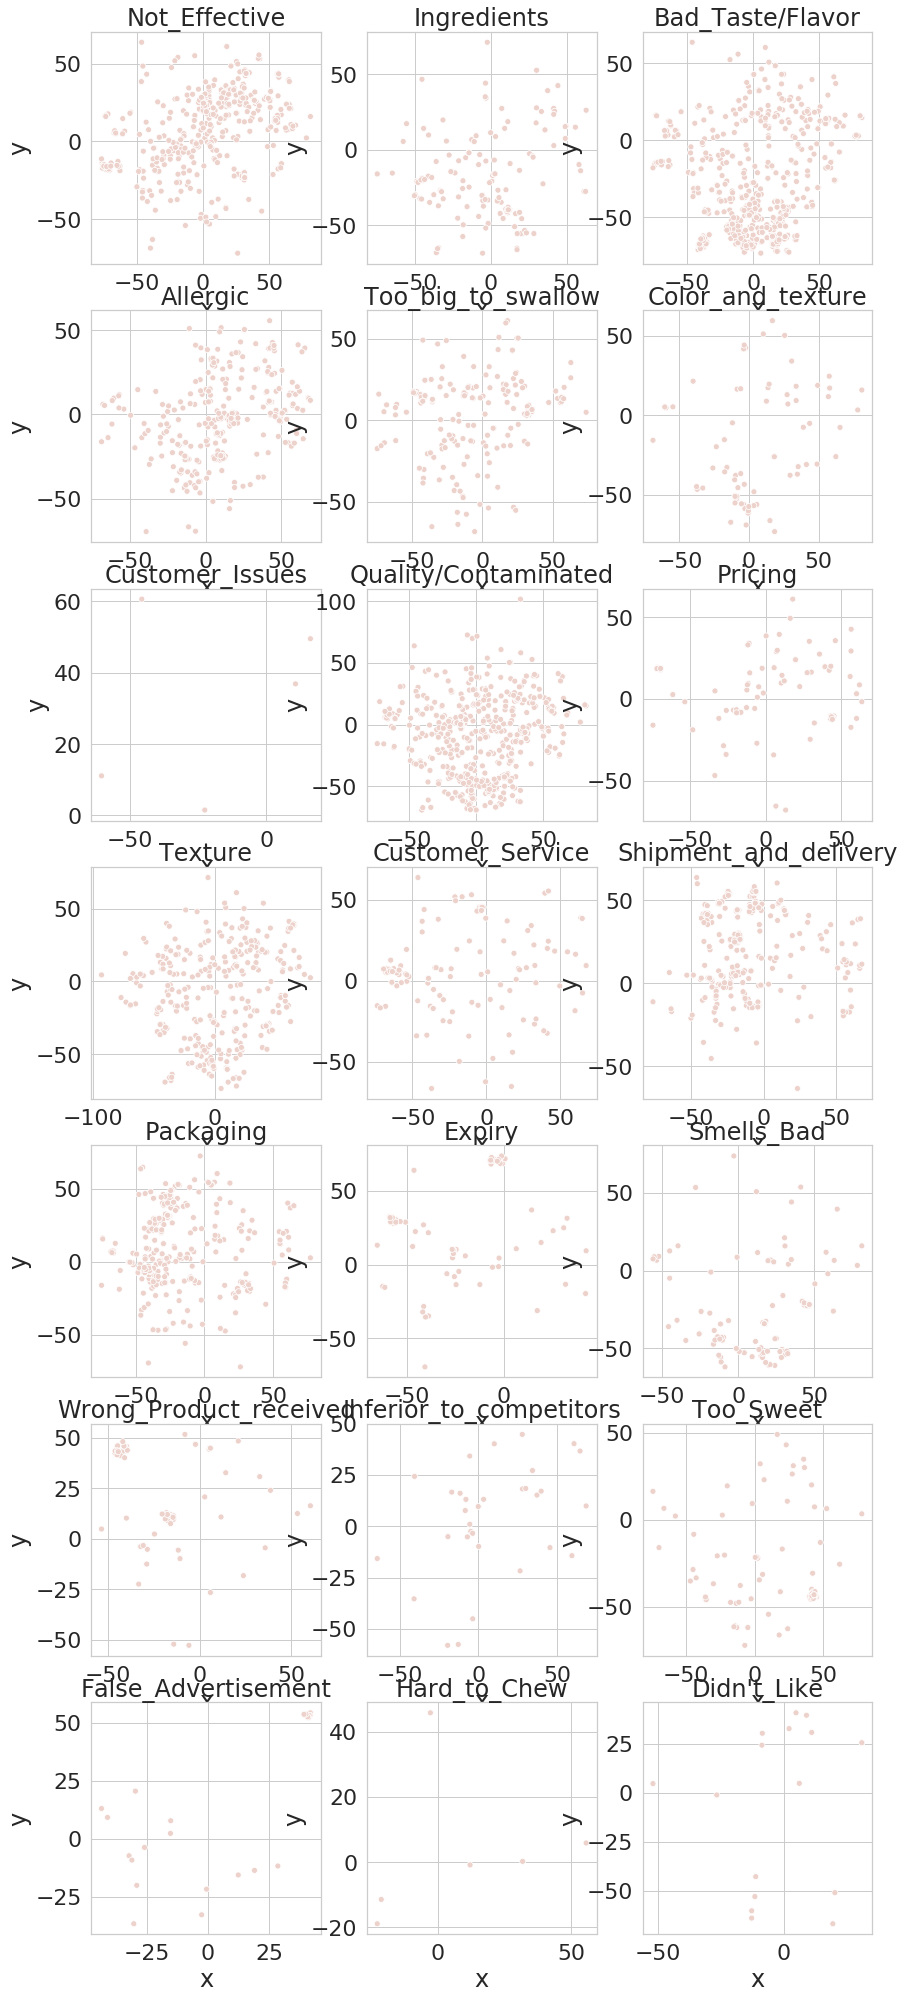

In [122]:
fig, ax = plt.subplots(7,3,figsize=(14,35))
axes = ax.flatten()
topics = list(train4.topic.unique())
for ax,topic in zip(axes, topics):
    sns.scatterplot(x='x',y='y',hue='target', c='k', 
                    data=mapping2[mapping2.topic == topic], 
                    ax=ax, legend=False)
    ax.set_title(topic)

# plt.legend(loc='best')

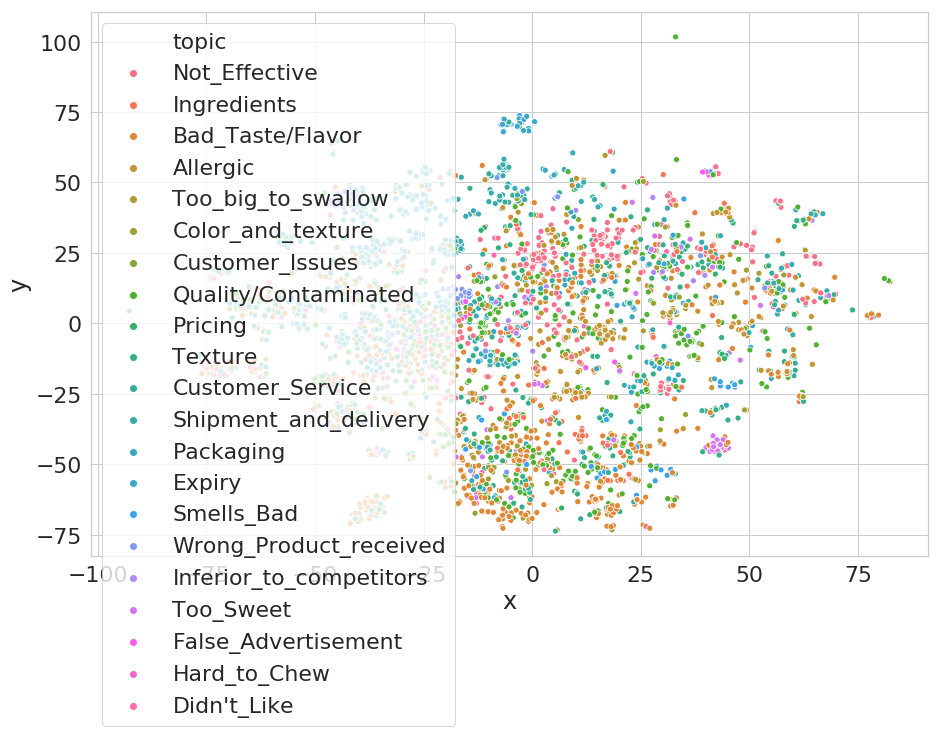

In [115]:
fig, ax = plt.subplots(1,1,figsize=(15,10))
sns.scatterplot(x='x',y='y',hue=train4['topic'], data=mapping2, ax=ax, legend='full')
# plt.legend(loc='best')

In [0]:
from sklearn.cluster import KMeans
y_pred = KMeans(n_clusters=21, random_state=1337).fit_predict(mapping_mean)


W0811 09:03:16.939636 140037554907008 legend.py:1289] No handles with labels found to put in legend.


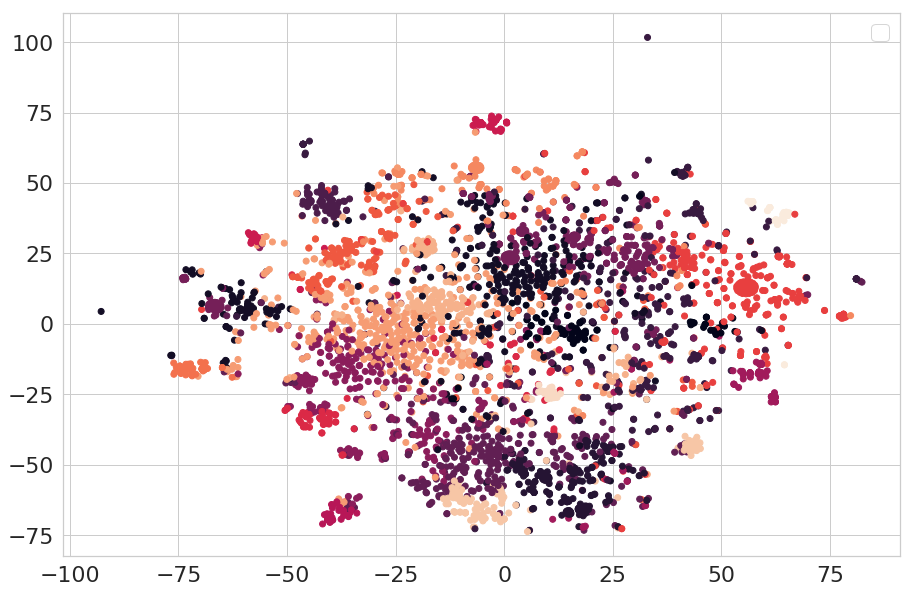

In [114]:
fig, ax = plt.subplots(1,1,figsize=(15,10))
# sns.scatterplot(x='x',y='y',hue='target', data=mapping2, ax=ax, legend='full')
ax.scatter(mapping_tsne[:,0], mapping_tsne[:,1], c=y_pred)
plt.legend(loc='best')

In [0]:
cl_mean = []
for topic in topics:
    cl_mean.append(mapping_mean[train4.topic == topic].mean(axis=0))

In [0]:
from sklearn.manifold import TSNE
tsne = TSNE(n_components=2)
cl_tsne = tsne.fit_transform(np.array(cl_mean).reshape(-1,300))

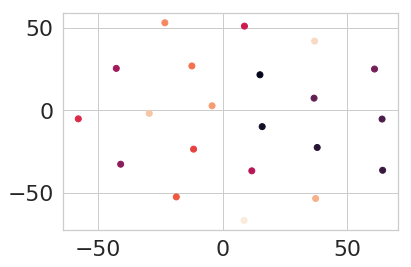

In [156]:
plt.scatter(cl_tsne[:,0], cl_tsne[:,1], c=range(21))

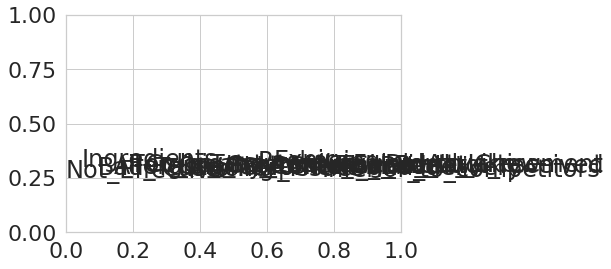

In [151]:
means = np.array(cl_mean).mean(axis=1)
for i, s, j in zip(range(21), topics, means):
    plt.text(i/21,j,s)

In [158]:
# plt.scatter(, c=range(21))
c1_ = list(cl_tsne[:,0])
c2_ = list(cl_tsne[:,1])
for i,j,s in zip(c1_, c2_, topics):
    plt.text(i,j,s)

In [159]:
gc.collect()

15351

In [161]:
!ls submission/

deep_att_lstm.csv


In [0]:
from google.colab import files
files.download('submission/deep_att_lstm.csv')